## 문제 S-3: 뉴욕에서 출생한 신생아 분석

In [5]:
import pyspark

spark = pyspark.sql.SparkSession\
    .builder\
    .master("local")\
    .appName("midprac02")\
    .config(conf=pyspark.SparkConf())\
    .getOrCreate()

21/10/23 13:07:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/10/23 13:07:50 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


#### 1. Data requests

In [10]:
import json
import requests

url = "https://health.data.ny.gov/api/views/jxy9-yhdk/rows.json?accessType=DOWNLOAD"
data = requests.get(url).json()

In [27]:
data['meta']['view'].keys()

dict_keys(['id', 'name', 'assetType', 'attribution', 'attributionLink', 'averageRating', 'category', 'createdAt', 'description', 'displayType', 'downloadCount', 'hideFromCatalog', 'hideFromDataJson', 'indexUpdatedAt', 'newBackend', 'numberOfComments', 'oid', 'provenance', 'publicationAppendEnabled', 'publicationDate', 'publicationGroup', 'publicationStage', 'rowClass', 'rowsUpdatedAt', 'rowsUpdatedBy', 'tableId', 'totalTimesRated', 'viewCount', 'viewLastModified', 'viewType', 'approvals', 'columns', 'grants', 'metadata', 'owner', 'query', 'rights', 'tableAuthor', 'tags', 'flags'])

In [37]:
from pyspark.sql import Row

data1 = data['data'][0]
Row([data1[8], data1[9], data1[10], data1[11], data1[12]])

<Row(['2007', 'ZOEY', 'KINGS', 'F', '11'])>

In [50]:
babyRows = [Row(*x[8:13]) for x in data['data']]

babyNYDf = spark.createDataFrame(babyRows)

In [44]:
babyNYDf.printSchema()

root
 |-- _1: string (nullable = true)
 |-- _2: string (nullable = true)
 |-- _3: string (nullable = true)
 |-- _4: string (nullable = true)
 |-- _5: string (nullable = true)



In [51]:
babyNYDf = babyNYDf.withColumnRenamed("_1", "year")
babyNYDf = babyNYDf.withColumnRenamed("_2", "firstName")
babyNYDf = babyNYDf.withColumnRenamed("_3", "country")
babyNYDf = babyNYDf.withColumnRenamed("_4", "sex")
babyNYDf = babyNYDf.withColumn("count", babyNYDf['_5'].cast("integer")).drop("_5")

In [53]:
babyNYDf.printSchema()
babyNYDf.show(5)

root
 |-- year: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- country: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- count: integer (nullable = true)



21/10/23 13:32:38 WARN TaskSetManager: Stage 0 contains a task of very large size (2635 KiB). The maximum recommended task size is 1000 KiB.


+----+---------+-------+---+-----+
|year|firstName|country|sex|count|
+----+---------+-------+---+-----+
|2007|     ZOEY|  KINGS|  F|   11|
|2007|     ZOEY|SUFFOLK|  F|    6|
|2007|     ZOEY| MONROE|  F|    6|
|2007|     ZOEY|   ERIE|  F|    9|
|2007|      ZOE| ULSTER|  F|    5|
+----+---------+-------+---+-----+
only showing top 5 rows



In [55]:
babyNYDf.registerTempTable("babyNY")
spark.sql("SELECT distinct(firstName) from babyNY").show()

21/10/23 13:35:36 WARN TaskSetManager: Stage 1 contains a task of very large size (2635 KiB). The maximum recommended task size is 1000 KiB.


+---------+
|firstName|
+---------+
|     JADE|
|   HUNTER|
|     ANNA|
|   ANJALI|
|     LEIB|
|   MILANA|
|   ZARIAH|
|PRINCETON|
|   BLIMIE|
|   SELINA|
|    PETER|
|  MAXWELL|
|  MATTHEW|
|  EMANUEL|
|      ELI|
|  NECHUMA|
|  YOANDRI|
|    SKYLA|
|    MATEO|
|    GRACE|
+---------+
only showing top 20 rows



In [59]:
babyNYDf.groupBy("year").pivot("sex").max().show()

21/10/23 13:38:00 WARN TaskSetManager: Stage 41 contains a task of very large size (2635 KiB). The maximum recommended task size is 1000 KiB.
21/10/23 13:38:01 WARN TaskSetManager: Stage 44 contains a task of very large size (2635 KiB). The maximum recommended task size is 1000 KiB.


+----+---+---+
|year|  F|  M|
+----+---+---+
|2016|191|227|
|2012|204|273|
|2017|226|248|
|2014|206|245|
|2013|204|272|
|2018|211|244|
|2009|186|287|
|2011|199|268|
|2008|191|259|
|2007|199|258|
|2015|200|273|
|2010|211|297|
+----+---+---+



## 예제 카피

In [60]:
myList = [
    ("1", "kim, js", 170),
    ("1", "lee, sm", 175),
    ("2", "lim, yg", 180),
    ("2", "lee, hg", 170)
]

myDf = spark.createDataFrame(myList)
myDf.show()

+---+-------+---+
| _1|     _2| _3|
+---+-------+---+
|  1|kim, js|170|
|  1|lee, sm|175|
|  2|lim, yg|180|
|  2|lee, hg|170|
+---+-------+---+



In [61]:
myDf.columns

['_1', '_2', '_3']

In [62]:
cols = ["year", "name", "height"]
myDf = spark.createDataFrame(myList, cols)
myDf.show()

+----+-------+------+
|year|   name|height|
+----+-------+------+
|   1|kim, js|   170|
|   1|lee, sm|   175|
|   2|lim, yg|   180|
|   2|lee, hg|   170|
+----+-------+------+



In [67]:
names = ["kim", "lee", "won", "lim"]
items = ["espresso", "latte", "americano", "affogato", "long black", "macciato"]
coffeeDf = spark.createDataFrame( [[names[i%4], items[i%6]] for i in range(100)], ["names", "coffee"])
coffeeDf.show()

+-----+----------+
|names|    coffee|
+-----+----------+
|  kim|  espresso|
|  lee|     latte|
|  won| americano|
|  lim|  affogato|
|  kim|long black|
|  lee|  macciato|
|  won|  espresso|
|  lim|     latte|
|  kim| americano|
|  lee|  affogato|
|  won|long black|
|  lim|  macciato|
|  kim|  espresso|
|  lee|     latte|
|  won| americano|
|  lim|  affogato|
|  kim|long black|
|  lee|  macciato|
|  won|  espresso|
|  lim|     latte|
+-----+----------+
only showing top 20 rows



In [68]:
coffeeDf.printSchema()

root
 |-- names: string (nullable = true)
 |-- coffee: string (nullable = true)



In [69]:
from pyspark.sql import Row

Person = Row("year", "name", "height")
row1 = Person("1", "kim, js", 170)

In [71]:
print(row1.year, row1.name, row1.height)

1 kim, js 170


In [72]:
row1.asDict()

{'year': '1', 'name': 'kim, js', 'height': 170}

In [82]:
from pyspark.sql.types import StructField, StructType
from pyspark.sql.types import StringType, IntegerType, FloatType

mySchema = StructType([
    StructField("year", StringType(), True),
    StructField("name", StringType(), True),
    StructField("height", IntegerType(), True)
])

In [137]:
hwRdd = spark.sparkContext.textFile("data/ds_spark_height_weight.tsv")
_hwRdd = hwRdd\
    .map(lambda x: x.split('\t'))

header = _hwRdd.first()
_hwRdd = _hwRdd.filter(lambda line: line != header)

_hwRdd = _hwRdd.map(lambda x: (int(x[0]), float(x[1]), float(x[2])))

_hwRdd.take(20)

[(1, 65.78331, 112.9925),
 (2, 71.51521, 136.4873),
 (3, 69.39874, 153.0269),
 (4, 68.2166, 142.3354),
 (5, 67.78781, 144.2971),
 (6, 68.69784, 123.3024),
 (7, 69.80204, 141.4947),
 (8, 70.01472, 136.4623),
 (9, 67.90265, 112.3723),
 (10, 66.78236, 120.6672),
 (11, 66.48769, 127.4516),
 (12, 67.62333, 114.143),
 (13, 68.30248, 125.6107),
 (14, 67.11656, 122.4618),
 (15, 68.27967, 116.0866),
 (16, 71.0916, 139.9975),
 (17, 66.461, 129.5023),
 (18, 68.64927, 142.9733),
 (19, 71.23033, 137.9025),
 (20, 67.13118, 124.0449)]

In [138]:
hwSchema = StructType([
    StructField("index", IntegerType(), True),
    StructField("weight", DoubleType(), True),
    StructField("height", DoubleType(), True)
])

In [139]:
_hwDf = spark.createDataFrame(_hwRdd, hwSchema)
_hwDf.show(5)
_hwDf.printSchema()

+-----+--------+--------+
|index|  weight|  height|
+-----+--------+--------+
|    1|65.78331|112.9925|
|    2|71.51521|136.4873|
|    3|69.39874|153.0269|
|    4| 68.2166|142.3354|
|    5|67.78781|144.2971|
+-----+--------+--------+
only showing top 5 rows

root
 |-- index: integer (nullable = true)
 |-- weight: double (nullable = true)
 |-- height: double (nullable = true)



In [141]:
hwDf = spark.read.options(header="true", inferschema="true", delimiter="\t")\
            .csv("data/ds_spark_height_weight.tsv")

hwDf.show()

+---+--------------+--------------+
|dex|Height(Inches)|Weight(Pounds)|
+---+--------------+--------------+
|  1|      65.78331|      112.9925|
|  2|      71.51521|      136.4873|
|  3|      69.39874|      153.0269|
|  4|       68.2166|      142.3354|
|  5|      67.78781|      144.2971|
|  6|      68.69784|      123.3024|
|  7|      69.80204|      141.4947|
|  8|      70.01472|      136.4623|
|  9|      67.90265|      112.3723|
| 10|      66.78236|      120.6672|
| 11|      66.48769|      127.4516|
| 12|      67.62333|       114.143|
| 13|      68.30248|      125.6107|
| 14|      67.11656|      122.4618|
| 15|      68.27967|      116.0866|
| 16|       71.0916|      139.9975|
| 17|        66.461|      129.5023|
| 18|      68.64927|      142.9733|
| 19|      71.23033|      137.9025|
| 20|      67.13118|      124.0449|
+---+--------------+--------------+
only showing top 20 rows



In [147]:
hwDf.select("Height(Inches)", "Weight(Pounds)").describe().show()

+-------+------------------+------------------+
|summary|    Height(Inches)|    Weight(Pounds)|
+-------+------------------+------------------+
|  count|             25000|             25000|
|   mean| 67.99311359679979|127.07942116079916|
| stddev|1.9016787712056056|11.660897563604271|
|    min|          60.27836|          78.01476|
|    max|           75.1528|           170.924|
+-------+------------------+------------------+



In [151]:
inch2cm = F.udf(lambda x: 2.54 * x, DoubleType())
pound2kg = F.udf(lambda x: 0.4535 * x, DoubleType())

hwDf = hwDf.withColumn("Height(cm)", inch2cm(hwDf["Height(Inches)"]))
hwDf = hwDf.withColumn("Weight(kg)", pound2kg(hwDf["Weight(Pounds)"]))
hwDf = hwDf.drop("Height(Inches)", "Weight(Pounds)")

hwDf.show()

+---+------------------+------------------+
|dex|        Height(cm)|        Weight(kg)|
+---+------------------+------------------+
|  1|       167.0896074|51.242098750000004|
|  2|       181.6486334|61.896990550000005|
|  3|       176.2727996| 69.39769915000001|
|  4|        173.270164|        64.5491039|
|  5|172.18103739999998|       65.43873485|
|  6|       174.4925136|        55.9176384|
|  7|177.29718160000002|       64.16784645|
|  8|177.83738879999999|       61.88565305|
|  9|172.47273099999998|       50.96083805|
| 10|       169.6271944|        54.7225752|
| 11|       168.8787326|        57.7993006|
| 12|       171.7632582|51.763850500000004|
| 13|       173.4882992|56.964452449999996|
| 14|170.47606240000002|        55.5364263|
| 15|       173.4303618|52.645273100000004|
| 16|        180.572664|       63.48886625|
| 17|         168.81094|58.729293049999995|
| 18|       174.3691458|       64.83839155|
| 19|       180.9250382|       62.53878375|
| 20|       170.5131972|       5

In [154]:
hwDf.select("Height(cm)", "Weight(kg)").describe().show()

+-------+------------------+-----------------+
|summary|        Height(cm)|       Weight(kg)|
+-------+------------------+-----------------+
|  count|             25000|            25000|
|   mean|172.70250853587314|57.63051749642258|
| stddev| 4.830264078862244|5.288217045094535|
|    min|       153.1070344|      35.37969366|
|    max|        190.888112|77.51403400000001|
+-------+------------------+-----------------+



In [161]:
import json

with open("data/ds_twiiter_seoul_3.json", "r") as f:
    tweetData = f.readlines()
    tweetJson = json.loads(tweetData[0])

In [169]:
Row(**tweetJson)

Row(contributors=None, truncated=False, text='RT @soompi: #SEVENTEEN’s Mingyu, Jin Se Yeon, And Leeteuk To MC For 2016 Super Seoul Dream Concert \nhttps://t.co/1XRSaRBbE0 https://t.co/fi…', is_quote_status=False, in_reply_to_status_id=None, id=801657325836763136, favorite_count=0, entities={'symbols': [], 'user_mentions': [{'id': 17659206, 'indices': [3, 10], 'id_str': '17659206', 'screen_name': 'soompi', 'name': 'Soompi'}], 'hashtags': [{'indices': [12, 22], 'text': 'SEVENTEEN'}], 'urls': [{'url': 'https://t.co/1XRSaRBbE0', 'indices': [100, 123], 'expanded_url': 'http://www.soompi.com/2016/11/20/seventeens-mingyu-jin-se-yeon-leeteuk-mc-dream-concert/', 'display_url': 'soompi.com/2016/11/20/sev…'}]}, retweeted=False, coordinates=None, source='<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>', in_reply_to_screen_name=None, in_reply_to_user_id=None, retweet_count=1487, id_str='801657325836763136', favorited=False, retweeted_status={'contributors': None

In [170]:
import pandas as pd

tweetPd = pd.read_json("data/ds_twiiter_seoul_3.json")
tweetPd

,contributors,truncated,text,is_quote_status,in_reply_to_status_id,id,favorite_count,entities,retweeted,coordinates,...,retweeted_status,user,geo,in_reply_to_user_id_str,possibly_sensitive,lang,created_at,in_reply_to_status_id_str,place,metadata
symbols,NaN,False,"RT @soompi: #SEVENTEEN’s Mingyu, Jin Se Yeon, ...",False,NaN,801657325836763136,0,[],False,NaN,...,NaN,NaN,NaN,NaN,False,en,2016-11-24 05:22:55+00:00,NaN,NaN,NaN
user_mentions,NaN,False,"RT @soompi: #SEVENTEEN’s Mingyu, Jin Se Yeon, ...",False,NaN,801657325836763136,0,"[{'id': 17659206, 'indices': [3, 10], 'id_str'...",False,NaN,...,NaN,NaN,NaN,NaN,False,en,2016-11-24 05:22:55+00:00,NaN,NaN,NaN
hashtags,NaN,False,"RT @soompi: #SEVENTEEN’s Mingyu, Jin Se Yeon, ...",False,NaN,801657325836763136,0,"[{'indices': [12, 22], 'text': 'SEVENTEEN'}]",False,NaN,...,NaN,NaN,NaN,NaN,False,en,2016-11-24 05:22:55+00:00,NaN,NaN,NaN
urls,NaN,False,"RT @soompi: #SEVENTEEN’s Mingyu, Jin Se Yeon, ...",False,NaN,801657325836763136,0,"[{'url': 'https://t.co/1XRSaRBbE0', 'indices':...",False,NaN,...,NaN,NaN,NaN,NaN,False,en,2016-11-24 05:22:55+00:00,NaN,NaN,NaN
contributors,NaN,False,"RT @soompi: #SEVENTEEN’s Mingyu, Jin Se Yeon, ...",False,NaN,801657325836763136,0,NaN,False,NaN,...,NaN,NaN,NaN,NaN,False,en,2016-11-24 05:22:55+00:00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
protected,NaN,False,"RT @soompi: #SEVENTEEN’s Mingyu, Jin Se Yeon, ...",False,NaN,801657325836763136,0,NaN,False,NaN,...,NaN,False,NaN,NaN,False,en,2016-11-24 05:22:55+00:00,NaN,NaN,NaN
default_profile,NaN,False,"RT @soompi: #SEVENTEEN’s Mingyu, Jin Se Yeon, ...",False,NaN,801657325836763136,0,NaN,False,NaN,...,NaN,True,NaN,NaN,False,en,2016-11-24 05:22:55+00:00,NaN,NaN,NaN
is_translator,NaN,False,"RT @soompi: #SEVENTEEN’s Mingyu, Jin Se Yeon, ...",False,NaN,801657325836763136,0,NaN,False,NaN,...,NaN,False,NaN,NaN,False,en,2016-11-24 05:22:55+00:00,NaN,NaN,NaN
iso_language_code,NaN,False,"RT @soompi: #SEVENTEEN’s Mingyu, Jin Se Yeon, ...",False,NaN,801657325836763136,0,NaN,False,NaN,...,NaN,NaN,NaN,NaN,False,en,2016-11-24 05:22:55+00:00,NaN,NaN,en


In [171]:
tweetDf = spark.read.json("data/ds_twiiter_seoul_3.json")
tweetDf.show()

+------------+-----------+--------------------+--------------------+--------------+---------+----+------------------+------------------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+---------------+----+------------+-----+------------------+-------------+---------+--------------------+--------------------+--------------------+---------+--------------------+
|contributors|coordinates|          created_at|            entities|favorite_count|favorited| geo|                id|            id_str|in_reply_to_screen_name|in_reply_to_status_id|in_reply_to_status_id_str|in_reply_to_user_id|in_reply_to_user_id_str|is_quote_status|lang|    metadata|place|possibly_sensitive|retweet_count|retweeted|    retweeted_status|              source|                text|truncated|                user|
+------------+-----------+--------------------+--------------------+--------------+---------+----+------------------+------------------+----

In [173]:
tweetDf.printSchema()

root
 |-- contributors: string (nullable = true)
 |-- coordinates: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- symbols: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- urls: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- url: string (nullable = true)
 |    |-- user_mentions: array (nullable = true)
 |    |    |-- element: struct (containsNull 

In [174]:
hwDf.show()

+---+------------------+------------------+
|dex|        Height(cm)|        Weight(kg)|
+---+------------------+------------------+
|  1|       167.0896074|51.242098750000004|
|  2|       181.6486334|61.896990550000005|
|  3|       176.2727996| 69.39769915000001|
|  4|        173.270164|        64.5491039|
|  5|172.18103739999998|       65.43873485|
|  6|       174.4925136|        55.9176384|
|  7|177.29718160000002|       64.16784645|
|  8|177.83738879999999|       61.88565305|
|  9|172.47273099999998|       50.96083805|
| 10|       169.6271944|        54.7225752|
| 11|       168.8787326|        57.7993006|
| 12|       171.7632582|51.763850500000004|
| 13|       173.4882992|56.964452449999996|
| 14|170.47606240000002|        55.5364263|
| 15|       173.4303618|52.645273100000004|
| 16|        180.572664|       63.48886625|
| 17|         168.81094|58.729293049999995|
| 18|       174.3691458|       64.83839155|
| 19|       180.9250382|       62.53878375|
| 20|       170.5131972|       5

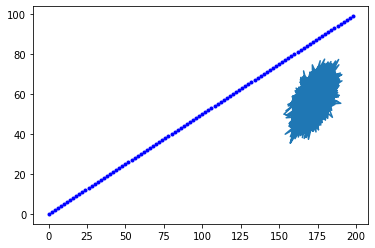

In [186]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

np.array(hwDf.select("Height(cm)").rdd.collect())
plt.plot(
    np.array(hwDf.select("Height(cm)").rdd.collect()),
    np.array(hwDf.select("Weight(kg)").rdd.collect()),
    'b.'
)

In [197]:
import pyspark.sql.functions as F



hwDf.select(*hwDf.columns, F.when(hwDf["Height(cm)"] < 150, 1).otherwise(0).alias("<150")).show()

+---+------------------+------------------+----+
|dex|        Height(cm)|        Weight(kg)|<150|
+---+------------------+------------------+----+
|  1|       167.0896074|51.242098750000004|   0|
|  2|       181.6486334|61.896990550000005|   0|
|  3|       176.2727996| 69.39769915000001|   0|
|  4|        173.270164|        64.5491039|   0|
|  5|172.18103739999998|       65.43873485|   0|
|  6|       174.4925136|        55.9176384|   0|
|  7|177.29718160000002|       64.16784645|   0|
|  8|177.83738879999999|       61.88565305|   0|
|  9|172.47273099999998|       50.96083805|   0|
| 10|       169.6271944|        54.7225752|   0|
| 11|       168.8787326|        57.7993006|   0|
| 12|       171.7632582|51.763850500000004|   0|
| 13|       173.4882992|56.964452449999996|   0|
| 14|170.47606240000002|        55.5364263|   0|
| 15|       173.4303618|52.645273100000004|   0|
| 16|        180.572664|       63.48886625|   0|
| 17|         168.81094|58.729293049999995|   0|
| 18|       174.3691

In [208]:
grp1 = hwDf.where(150 <= hwDf["Height(cm)"]).where(hwDf["Height(cm)"] < 160)
grp2 = hwDf.where(160 <= hwDf["Height(cm)"]).where(hwDf["Height(cm)"] < 170)
grp3 = hwDf.where(170 <= hwDf["Height(cm)"]).where(hwDf["Height(cm)"] < 180)
grp4 = hwDf.where(180 <= hwDf["Height(cm)"]).where(hwDf["Height(cm)"] < 190)

(array([ 2.,  3.,  1.,  6.,  3.,  7.,  7.,  5.,  2., 10.,  6.,  8.,  5.,
         6.,  8.,  8.,  3.,  3.,  4.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
        57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
        74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]),
 <BarContainer object of 49 artists>)

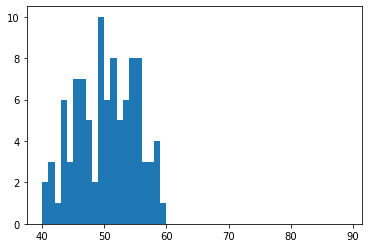

In [230]:
plt.hist(
    np.array(grp1.select("Weight(kg)").rdd.collect()),
    bins=range(40, 90)
)

(array([  8.,  11.,  33.,  42.,  50., 115., 133., 198., 265., 320., 416.,
        507., 526., 557., 572., 612., 527., 482., 468., 361., 295., 200.,
        156.,  95.,  65.,  40.,  23.,   7.,   9.,   3.,   1.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.]),
 array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
        57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
        74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]),
 <BarContainer object of 49 artists>)

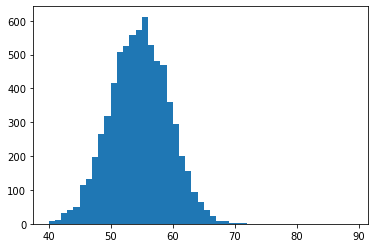

In [231]:
plt.hist(
    np.array(grp2.select("Weight(kg)").rdd.collect()),
    bins=range(40, 90)
)

(array([0.000e+00, 5.000e+00, 4.000e+00, 8.000e+00, 2.600e+01, 3.300e+01,
        6.200e+01, 9.600e+01, 1.780e+02, 2.060e+02, 3.460e+02, 4.400e+02,
        6.000e+02, 7.840e+02, 9.540e+02, 1.114e+03, 1.222e+03, 1.347e+03,
        1.306e+03, 1.299e+03, 1.249e+03, 1.128e+03, 9.380e+02, 7.950e+02,
        5.960e+02, 4.510e+02, 3.130e+02, 2.370e+02, 1.560e+02, 1.010e+02,
        7.600e+01, 2.600e+01, 2.700e+01, 8.000e+00, 4.000e+00, 4.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00]),
 array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
        57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
        74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]),
 <BarContainer object of 49 artists>)

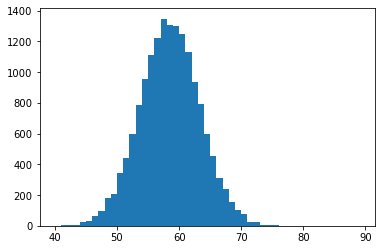

In [233]:
plt.hist(
    np.array(grp3.select("Weight(kg)").rdd.collect()),
    bins=range(40, 90)
)

(array([  0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   3.,   0.,   2.,
          4.,  12.,  16.,  33.,  37.,  57.,  77.,  98., 101., 129., 155.,
        131., 149., 122., 122.,  89.,  92.,  62.,  50.,  41.,  24.,  11.,
         12.,   3.,   5.,   3.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.]),
 array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
        57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
        74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]),
 <BarContainer object of 49 artists>)

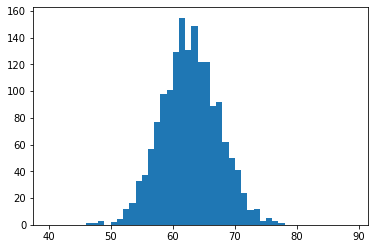

In [234]:
plt.hist(
    np.array(grp4.select("Weight(kg)").rdd.collect()),
    bins=range(40, 90)
)

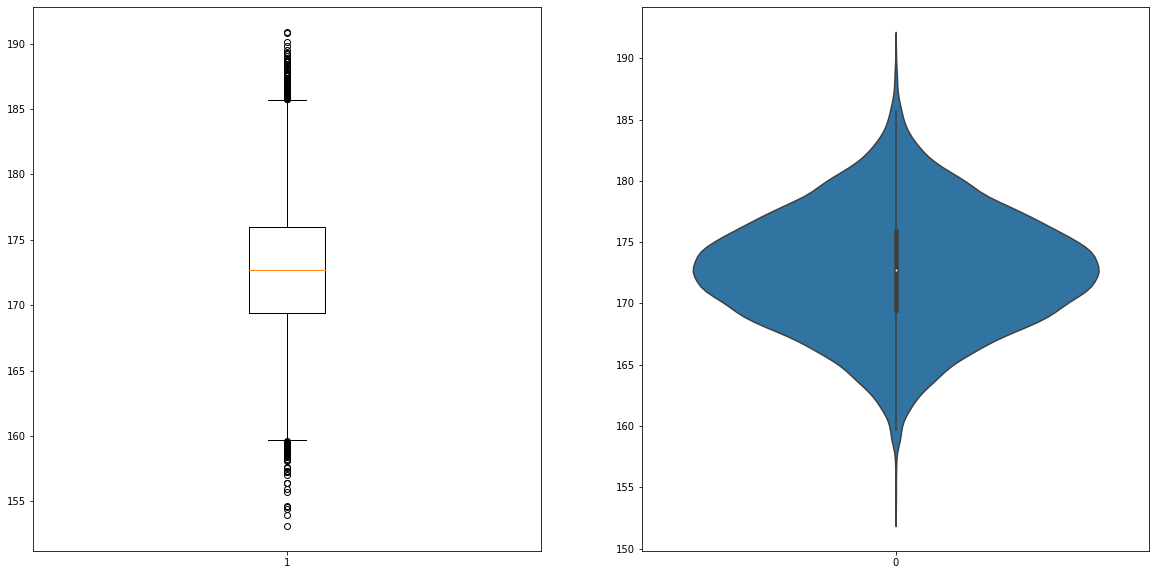

In [235]:
import seaborn as sns

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax1 = plt.boxplot(np.array(hwDf.select("Height(cm)").rdd.collect()))

ax2 = fig.add_subplot(1, 2, 2)
ax2 = sns.violinplot(data=np.array(hwDf.select("Height(cm)").rdd.collect()))

In [244]:
hwDf.select(
    F.mean("Height(cm)").alias("h_u"), 
    F.stddev("Height(cm)").alias("h_s"),
    F.mean("Weight(kg)").alias("w_u"),
    F.stddev("Weight(kg)").alias("w_s")
).rdd.collect()[0]["h_u"]

172.70250853587314